In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[GpuDevice(id=0), GpuDevice(id=1), GpuDevice(id=2), GpuDevice(id=3)]


# Process Data

In [5]:
# Confirmed Cases
c_df = transform.IRD(min_confirmed=100, min_recovered=0, min_deaths=0)[0]

In [6]:
c_df

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,120,170,174,237,273,281,299,349,367,423
Albania,0,0,0,0,0,0,0,0,0,0,...,212,223,243,259,277,304,333,361,377,383
Algeria,0,0,0,0,0,0,0,0,0,0,...,511,584,716,847,986,1171,1251,1320,1423,1468
Andorra,0,0,0,0,0,0,0,0,0,0,...,334,370,376,390,428,439,466,501,525,545
Argentina,0,0,0,0,0,0,0,0,0,0,...,745,820,1054,1054,1133,1265,1451,1451,1554,1628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uzbekistan,0,0,0,0,0,0,0,0,0,0,...,144,149,172,181,205,227,266,342,457,520
Venezuela,0,0,0,0,0,0,0,0,0,0,...,119,135,135,143,146,153,155,159,165,165
Vietnam,0,2,2,2,2,2,2,2,2,2,...,188,203,212,218,233,237,240,241,245,249


In [7]:
min_days = 14
max_days = 28
cases = {}
start_days = np.argmax((c_df.values>=70),axis=1)
for i, country in enumerate(c_df.index):
    if len(c_df.T[country].values[start_days[i]:])>=min_days:
        cases[country] = np.array(c_df.T[country].values[start_days[i]:start_days[i]+max_days]).astype(np.float32)

In [8]:
len(cases), len(c_df)

(102, 125)

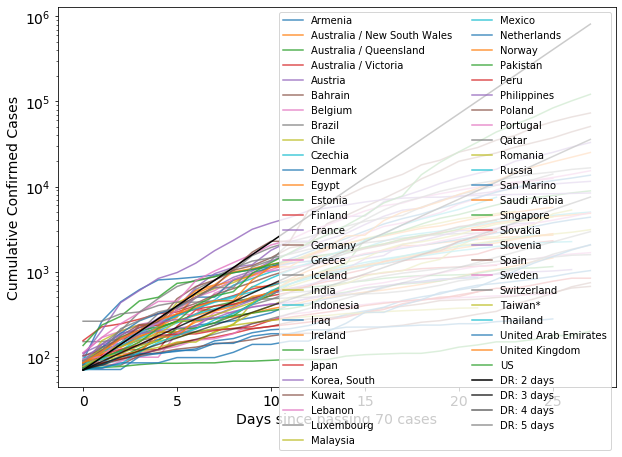

In [9]:
plt.figure(figsize=(10, 7))
t = np.arange(np.max([len(cases[c]) for c in cases.keys()]))
for i, c in enumerate(cases.keys()):
    if len(cases[c])>21:
        plt.semilogy(cases[c], alpha = 0.8, label=c)

for i in range(2, 6):
    plt.semilogy(t, 70*(2.0**(1.0/float(i)))**t, 'k', alpha=1.0-(i-2)*0.2, label=f'DR: {i} days')
    
plt.ylabel('Cumulative Confirmed Cases')
plt.xlabel('Days since passing 70 cases')
plt.legend(ncol=2, fontsize=10)

In [10]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(mean, std))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

In [11]:
def model():
    
    N = len(cases)
    
    ############
    # Initial Infection Rate
    Ii = normalHP('Ii', 100.0, 50.0, N)
    # Infection Growth Rate
    GR = normalHP('GR', 1.33, 0.5, N)
    
    # Create likelihood for each country
    for i, country in enumerate(list(cases.keys())):
        t = np.arange(len(cases[country]))
        confirmed = cases[country]
        
        # Likelihood
        numpyro.sample(country, dist.Poisson((Ii[i]*GR[i]**t)), # Exponential regression
                       obs=confirmed)

In [12]:
N = len(cases)
init_params = {'Ii_grp_mean': 100.0*np.ones((N_chains, 1)),
               'Ii_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'Ii_ind': 100.0*np.ones((N_chains, N)),
               'GR_grp_mean': 1.33*np.ones((N_chains, 1)),
               'GR_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'GR_ind': 1.33*np.ones((N_chains, N))
               }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2500, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [13]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

Time taken to compile model and draw samples : 11123.779036045074 s


In [44]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/2.0.2_EXPsamples_10k.h5', 'w') as fp:
    for key in samples:
        fp[key] = samples[key]
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
 GR_grp_mean[0]      1.12      0.00      1.12      1.11      1.13  18047.87      1.00
GR_grp_sigma[0]      0.05      0.00      0.05      0.04      0.05  13048.57      1.00
      GR_ind[0]      1.13      0.01      1.13      1.13      1.14  13784.21      1.00
      GR_ind[1]      1.09      0.00      1.09      1.09      1.10  10468.13      1.00
      GR_ind[2]      1.15      0.00      1.15      1.14      1.15  15931.48      1.00
      GR_ind[3]      1.10      0.00      1.10      1.09      1.10  12785.58      1.00
      GR_ind[4]      1.13      0.00      1.13      1.13      1.13  10196.10      1.00
      GR_ind[5]      1.11      0.00      1.11      1.11      1.11  14155.92      1.00
      GR_ind[6]      1.12      0.00      1.12      1.11      1.12  15655.68      1.00
      GR_ind[7]      1.09      0.00      1.09      1.09      1.10  10554.58      1.00
      GR_ind[8]      1.07      0.00      1.07      1.

In [17]:
samples = {}
with h5py.File('../data/nb_samples/2.0.2_EXPsamples_10k.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)].value

# Growth rate for all regions together

Text(0.5, 0, 'Growth Rate [day$^{-1}$]')

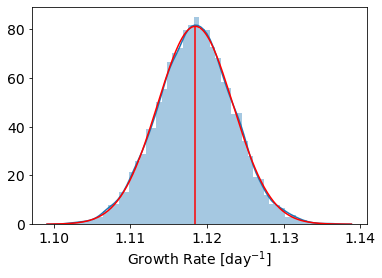

In [17]:
smp = samples['GR_grp_mean']
mn, std = norm.fit(smp)
sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
plt.vlines(mn, 0, norm.pdf(mn, mn, std), 'r')

plt.xlabel(r'Growth Rate [day$^{-1}$]')

# Growth rates for each region

Text(0.5, 0, 'Growth Rate [day$^{-1}$]')

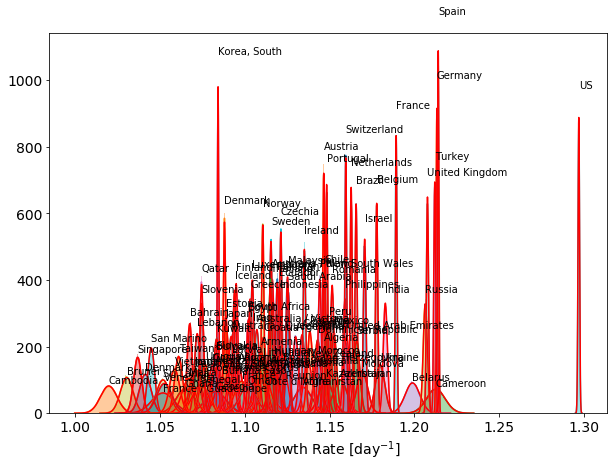

In [19]:
plt.figure(figsize=(10,7))
l_b, u_b = 1.0, 1.4

for i in range(N):
    smp = mcmc.get_samples()['GR_ind'][:,i]
    mn, std = norm.fit(smp)
    sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), list(cases.keys())[i], fontsize=10)

plt.xlabel(r'Growth Rate [day$^{-1}$]')
# plt.xlim(l_b, u_b)

# Example fits

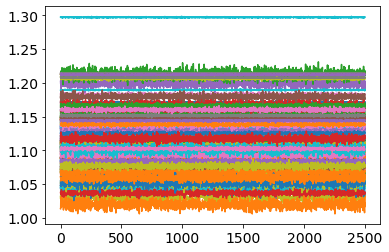

In [42]:
plt.plot(samples['GR_ind'][:2500]);

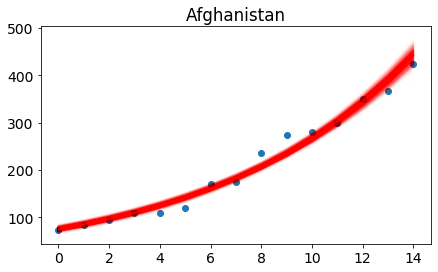

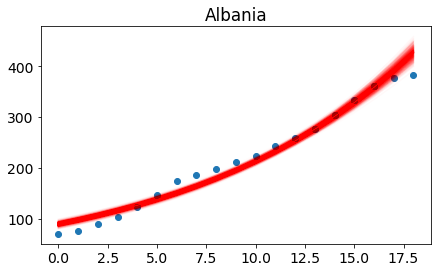

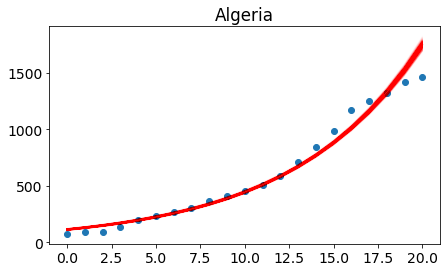

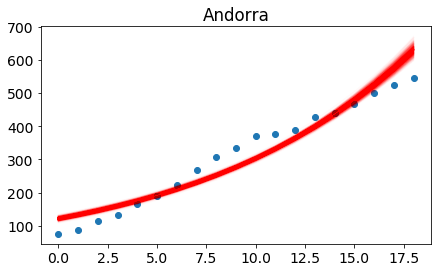

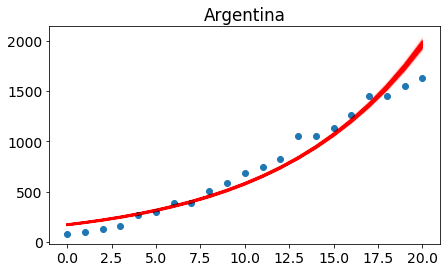

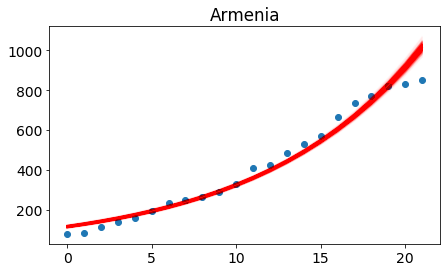

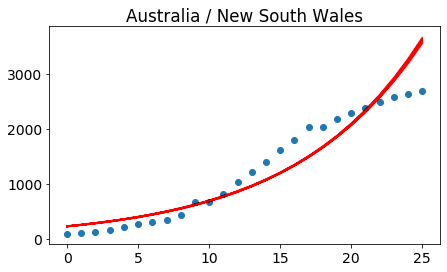

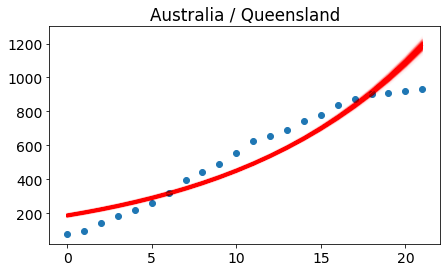

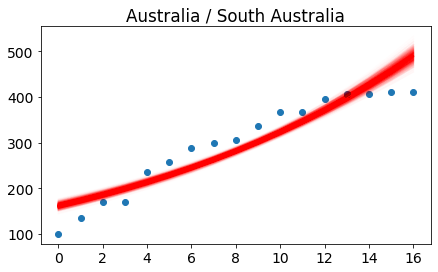

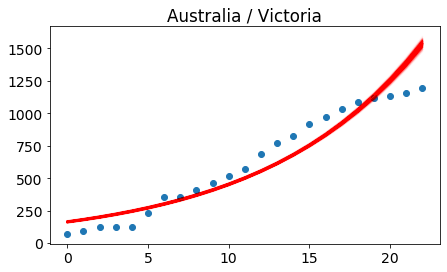

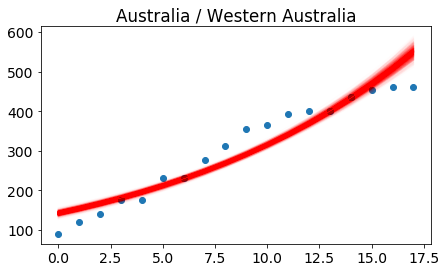

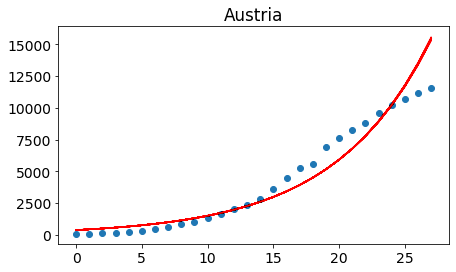

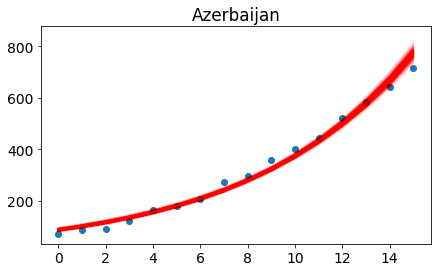

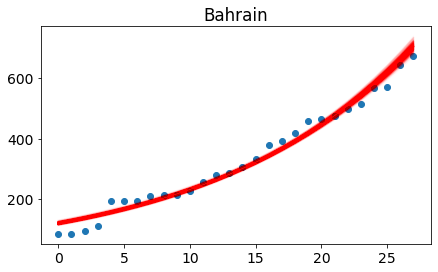

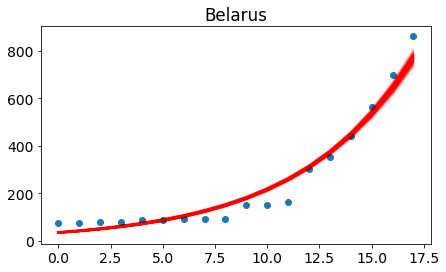

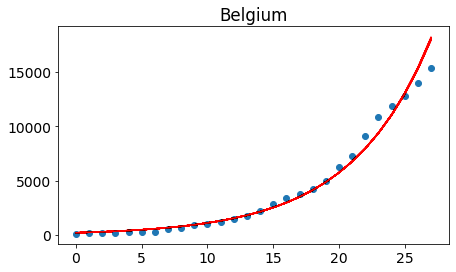

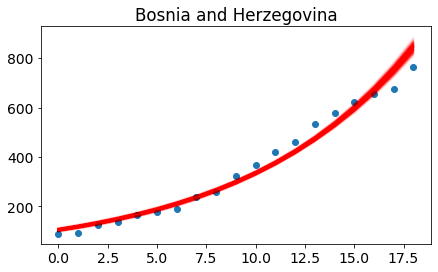

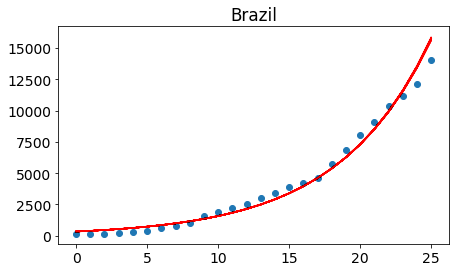

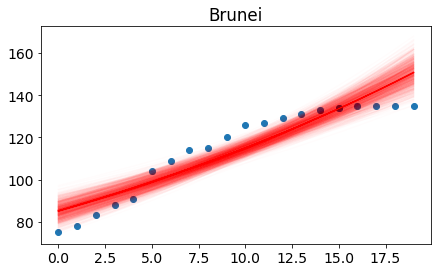

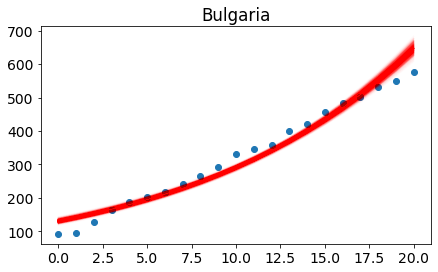

In [43]:
for i, c in enumerate(list(cases.keys())[:20]):
    plt.figure(figsize=(7, 4))
    t = np.arange(len(cases[c]))
    plt.title(c)
    plt.plot(cases[c], 'o')
    plt.plot(np.mean(samples['Ii_ind'][:,i])*np.mean(samples['GR_ind'][:,i])**t, 'r')
    plt.plot((samples['Ii_ind'][::10,i:i+1]*samples['GR_ind'][::10,i:i+1]**t[None,:]).T, 'r', alpha=0.01)
             